In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import jax
import jax.numpy as jnp

In [3]:
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.anderson_acceleration import anderson_method
from parametric_model.parametric_model import ParametricModel


In [24]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="resnet", # "node" "resnet"
    architecture=[2, 2, 64], # [input_dim, num_layers, hidden_width]
    activation_fn="tanh", # "tanh", "relu", "SinTu", "identity", "sigmoid", "gelu", "swish"
    time_dependent=False,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=0.1,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor=5e-2
)
# _,current_params  = nnx.split(parametric_model)

In [33]:
# Anderson parameters
h = 1e-2 # Time step size
m = 5 # Number of previous iterates to consider
beta = .75 # Damping parameter
max_iterations = 250
tolerance = 1e-8
n_samples = 2_000  # Monte Carlo sample size


key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)


# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(parametric_model)

solver= 'cg' # minres or cg


In [34]:
from functionals.functions import double_well_potential_fn, styblinski_tang_potential_fn, aggregation_potential_fn,zero_potential_fn
linear_potential = LinearPotential(potential_fn= styblinski_tang_potential_fn, coeff = 2.0)
internal_potential = InternalPotential(functional='entropy', coeff = .1, method= 'exact',prob_dim=2)
interaction_potential = InteractionPotential(interaction_fn = aggregation_potential_fn, coeff = 1, a = 4, b = 2)

potential = Potential(linear = None,
                      internal = None,
                      interaction = interaction_potential)

Starting Anderson-accelerated gradient flow
  n_iterations: 100
  step_size: 0.01
  memory_size: 5
  mixing_parameter: 0.75
------------------------------------------------------------
Iter    0 | Energy: 2.494144e+00 | Residual: 2.215902e-01 | 


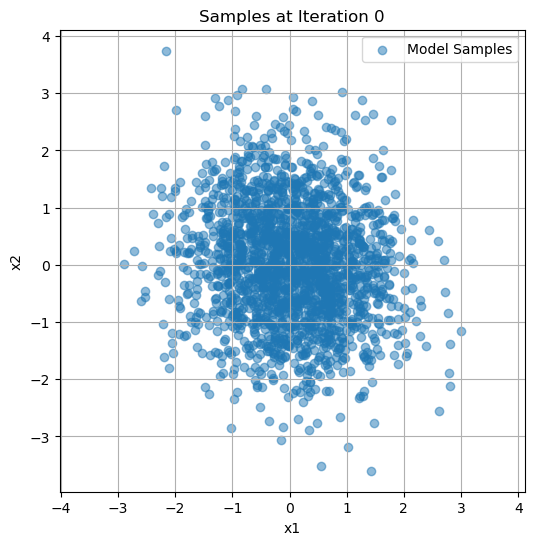

Iter    1 | Energy: 2.414814e+00 | Residual: 4.187682e-01 | 


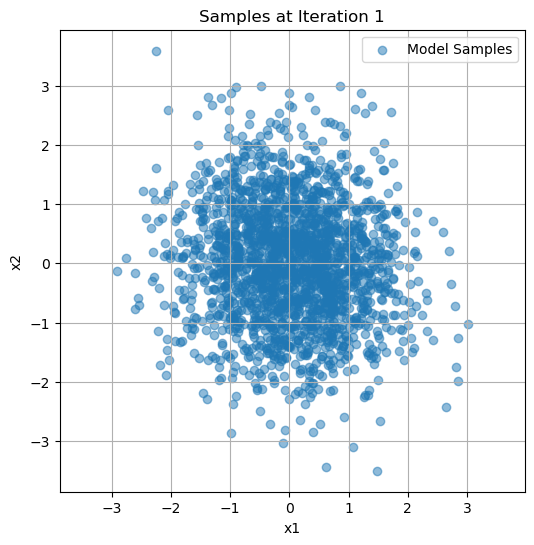

Iter    2 | Energy: 2.286618e+00 | Residual: 3.305925e-01 | 


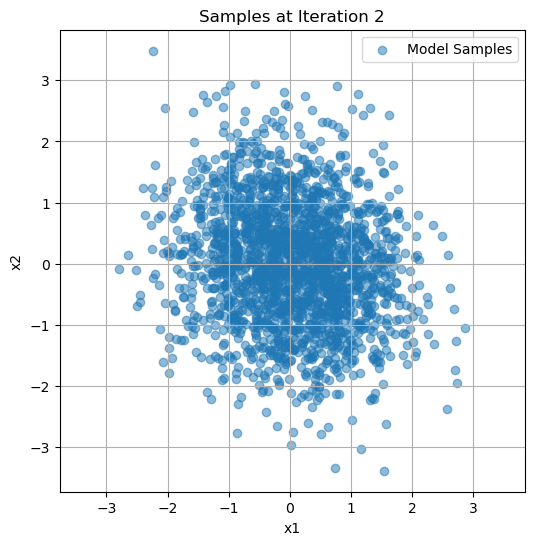

In [ ]:
current_params, history = anderson_method(
    parametric_model=parametric_model,
    batch_size=n_samples,
    test_data_set=z_samples,
    G_mat=G_mat_flow,
    potential=potential,
    initial_params= None,
    step_size=h,
    memory_size=m,
    mixing_parameter=beta,
    anderson_tol=1e-5,
    solver = solver,
    solver_tol=1e-4
)